In [1]:
%pylab inline

import pandas as pd
from tqdm import tqdm_notebook as tqdm

gold = 8.*np.array([1,1/((1+sqrt(5))/2)])

Populating the interactive namespace from numpy and matplotlib


In [2]:
# This function makes the plots look prettier on GitHub. 
### to do: figure out how to make this automatic.

def fix_boxplot(parts):
    for m in parts['fliers']:
        m.set_markersize(12)
        m.set_markeredgewidth(1)
    for b in parts['boxes']:
        b.set_linewidth(2)
    for w in parts['whiskers']:
        w.set_linewidth(2)
    for c in parts['caps']:
        c.set_linewidth(2)
    for m in parts['medians']:
        m.set_linewidth(2)
    for m in parts['means']:
        m.set_linewidth(2)
        m.set_color('g')
        m.set_markerfacecolor('g')

# Problem 2.2

In this problem, we're comparing methods of grouping in random trials. Examining the code written by the author, we have a trial response that is a normal variable centered on 0 and scaled by 1. A similar distribution is created as a lurking variable with a specified correlation to the response variable. The method of creating correlated random variables with correlation $\rho$ is done as follows:

<p style="margin-left: 80px">$r_1 \sim \mathrm{norm}(0,1)\\r_2 \sim \mathrm{norm}(0,1)\\x = \sqrt(1-\rho^2)\cdot r_2 + \rho \cdot r_1\\y = r_1$</p>

For the problem, we work with a total of 80 test participants (the *population*), and will divide them into four equally sized groups. The grouping will be first done completely randomly, and then by blocking for the lurking variable.

### Part A

The first trial uses a correlation of 0.8

In [3]:
rho = 0.8
lurking = np.random.normal(loc=0.,scale=1.,size=80)
response = sqrt(1-rho**2)*np.random.normal(loc=0.,scale=1.,size=80)+rho*lurking

population = pd.DataFrame(np.array([lurking,response]).T,columns=['lurking','response'])
population.describe()

,lurking,response
count,80.000000,80.000000
mean,0.167368,0.145806
std,1.020350,1.020069
min,-2.449122,-2.759297
25%,-0.410495,-0.496037
50%,0.138440,0.183620
75%,0.875928,0.869521
max,2.364015,2.538066


,lurking,response
lurking,1.00000,0.74859
response,0.74859,1.00000


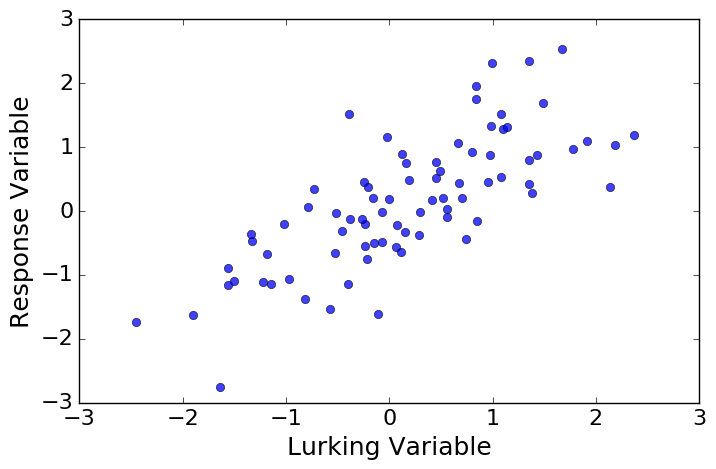

In [4]:
figure(figsize=gold)
plot(lurking,response,'o',alpha=0.75)
xlabel("Lurking Variable",fontsize=18)
ylabel("Response Variable",fontsize=18)
xticks(fontsize=16)
yticks(fontsize=16)
axis([-3,3,-3,3])
population.corr()

So far so good; the two variables are clearly correlated, and the correlation coefficient matches what we specified.

Next, we create the group assignments using some clever python programming rather than brute-forcing anything. This method speeds up the computation quite a bit!

500 random groupings are created for comparison.

In [5]:
# Start with empty DataFrames
experiment_response = pd.DataFrame(columns=['G1r','G2r','G3r','G4r','G1b','G2b','G3b','G4b'])
experiment_lurking = pd.DataFrame(columns=['G1r','G2r','G3r','G4r','G1b','G2b','G3b','G4b'])

for i in tqdm(range(500)):
    
    # simple random assignment
    random_groups = np.array([1,2,3,4]).repeat(20)
    np.random.shuffle(random_groups)

    # blocked assignment
    ### By finding the index order for the lurking variable with argsort, we can unravel
    ### the shuffled assignment to get the original index assignments this way:
    order = lurking.argsort()
    block_groups = np.array([[1,2,3,4]]).repeat(20,axis=0)
    for block in block_groups:
        np.random.shuffle(block)
    block_groups = block_groups.flatten()[order.argsort()]

    # create a DataFrame that includes the group assignments
    groups = population.copy()
    groups['random'] = pd.Series(random_groups, index=groups.index)
    groups['blocked'] = pd.Series(block_groups, index=groups.index)
    
    # find the mean response variable for each group and add to the DataFrame
    new_data = {'G1r':groups.groupby(by='random')['response'].mean()[1],
                'G2r':groups.groupby(by='random')['response'].mean()[2],
                'G3r':groups.groupby(by='random')['response'].mean()[3],
                'G4r':groups.groupby(by='random')['response'].mean()[4],
                'G1b':groups.groupby(by='blocked')['response'].mean()[1],
                'G2b':groups.groupby(by='blocked')['response'].mean()[2],
                'G3b':groups.groupby(by='blocked')['response'].mean()[3],
                'G4b':groups.groupby(by='blocked')['response'].mean()[4]}
    experiment_response = experiment_response.append(new_data, ignore_index=True)
    
    # find the mean lurking variable for each group and add to the DataFrame
    new_data = {'G1r':groups.groupby(by='random')['lurking'].mean()[1],
                'G2r':groups.groupby(by='random')['lurking'].mean()[2],
                'G3r':groups.groupby(by='random')['lurking'].mean()[3],
                'G4r':groups.groupby(by='random')['lurking'].mean()[4],
                'G1b':groups.groupby(by='blocked')['lurking'].mean()[1],
                'G2b':groups.groupby(by='blocked')['lurking'].mean()[2],
                'G3b':groups.groupby(by='blocked')['lurking'].mean()[3],
                'G4b':groups.groupby(by='blocked')['lurking'].mean()[4]}
    experiment_lurking = experiment_lurking.append(new_data, ignore_index=True)

Now that we've run our Monte Carlo simulation, it's time to look at the results. The two plots are for the distributions of the mean response and lurking variables for each respective group, labeled as 'GNx', with group number N and grouping type x for random (r) and blocked (b) groupings.

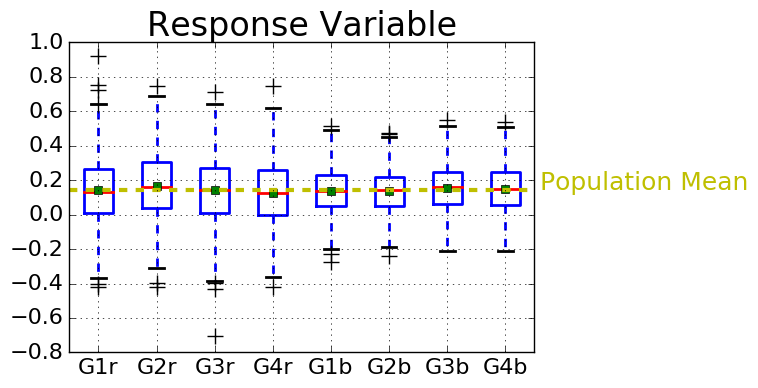

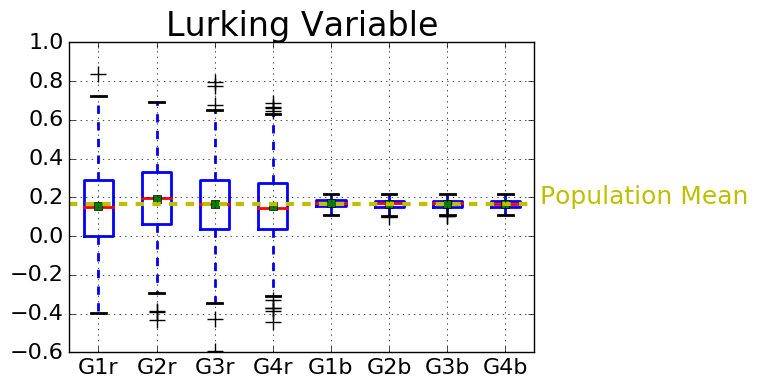

In [6]:
parts = experiment_response.boxplot(showmeans=True,figsize=gold,fontsize=16,return_type='dict')
fix_boxplot(parts)
yticks(fontsize=16)
title("Response Variable",fontsize=24)
plot([0.5,8.5],population.mean()['response']*np.ones(2),'y--',linewidth=3)
text(8.6,population.mean()['response'],"Population Mean",color='y',fontsize=18)

figure()
parts = experiment_lurking.boxplot(showmeans=True,figsize=gold,fontsize=16,return_type='dict')
fix_boxplot(parts)
yticks(fontsize=16)
title("Lurking Variable",fontsize=24)
plot([0.5,8.5],population.mean()['lurking']*np.ones(2),'y--',linewidth=3)
text(8.6,population.mean()['lurking'],"Population Mean",color='y',fontsize=18)

For the lurking variable, on average each group has the same mean, whether we do random or blocked grouping. What changes is how much variation there is in each value; for the random assignment, one group could have a mean lurking variable that is significantly low while another has one significantly high, for example. The variation in blocked grouping is quite small, and so we can average out the lurking variable in the study on the response variable more easily. This happens because blocked grouping intentionally distributes the population to keep the average lurking variable even across all groups.

The effect of blocked grouping on the study is readily apparent in the results for the response variable. Again, for this simple example, the response variable means for each group are approximately the same. However, the spread in the response variable is markedly less for the blocked groups than for the random groups. By blocking the groups, we remove the random variation due to the lurking variable (on average), and so we can get a more precise picture on the variation in the response variable.

As a result, a blocked grouping with a strongly correlated lurking variable makes a significant difference in the study's conclusions. If there were variations between groups, there would be a better chance of seeing them in the blocked grouping than the random grouping.

### Part B

Now we'll repeat the study with a less strongly correlated lurking variable, with $\rho = 0.4$.

In [7]:
rho = 0.4
lurking = np.random.normal(loc=0.,scale=1.,size=80)
response = sqrt(1-rho**2)*np.random.normal(loc=0.,scale=1.,size=80)+rho*lurking

population = pd.DataFrame(np.array([lurking,response]).T,columns=['lurking','response'])
population.describe()

,lurking,response
count,80.000000,80.000000
mean,-0.015881,0.020702
std,0.966372,0.981363
min,-2.415430,-3.215684
25%,-0.622619,-0.650428
50%,-0.164161,0.098016
75%,0.745650,0.691190
max,2.207396,1.950342


,lurking,response
lurking,1.000000,0.369516
response,0.369516,1.000000


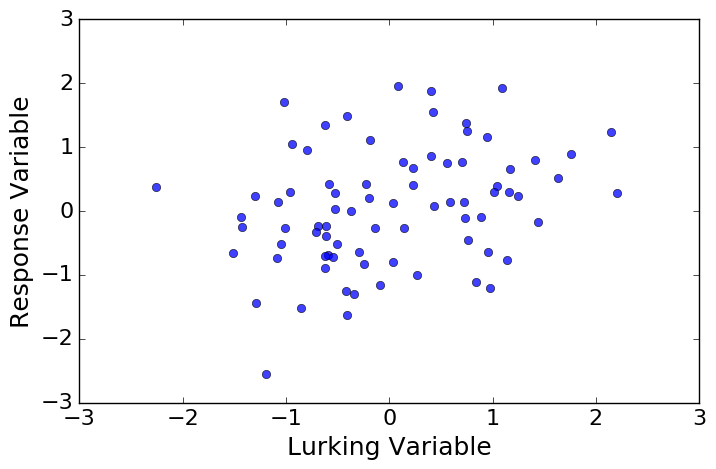

In [8]:
figure(figsize=gold)
plot(lurking,response,'o',alpha=0.75)
xlabel("Lurking Variable",fontsize=18)
ylabel("Response Variable",fontsize=18)
xticks(fontsize=16)
yticks(fontsize=16)
axis([-3,3,-3,3])
population.corr()

In [9]:
# Start with empty DataFrames
experiment_response = pd.DataFrame(columns=['G1r','G2r','G3r','G4r','G1b','G2b','G3b','G4b'])
experiment_lurking = pd.DataFrame(columns=['G1r','G2r','G3r','G4r','G1b','G2b','G3b','G4b'])

for i in tqdm(range(500)):
    
    # simple random assignment
    random_groups = np.array([1,2,3,4]).repeat(20)
    np.random.shuffle(random_groups)

    # blocked assignment
    ### By finding the index order for the lurking variable with argsort, we can unravel
    ### the shuffled assignment to get the original index assignments this way:
    order = lurking.argsort()
    block_groups = np.array([[1,2,3,4]]).repeat(20,axis=0)
    for block in block_groups:
        np.random.shuffle(block)
    block_groups = block_groups.flatten()[order.argsort()]

    # create a DataFrame that includes the group assignments
    groups = population.copy()
    groups['random'] = pd.Series(random_groups, index=groups.index)
    groups['blocked'] = pd.Series(block_groups, index=groups.index)
    
    # find the mean response variable for each group and add to the DataFrame
    new_data = {'G1r':groups.groupby(by='random')['response'].mean()[1],
                'G2r':groups.groupby(by='random')['response'].mean()[2],
                'G3r':groups.groupby(by='random')['response'].mean()[3],
                'G4r':groups.groupby(by='random')['response'].mean()[4],
                'G1b':groups.groupby(by='blocked')['response'].mean()[1],
                'G2b':groups.groupby(by='blocked')['response'].mean()[2],
                'G3b':groups.groupby(by='blocked')['response'].mean()[3],
                'G4b':groups.groupby(by='blocked')['response'].mean()[4]}
    experiment_response = experiment_response.append(new_data, ignore_index=True)
    
    # find the mean lurking variable for each group and add to the DataFrame
    new_data = {'G1r':groups.groupby(by='random')['lurking'].mean()[1],
                'G2r':groups.groupby(by='random')['lurking'].mean()[2],
                'G3r':groups.groupby(by='random')['lurking'].mean()[3],
                'G4r':groups.groupby(by='random')['lurking'].mean()[4],
                'G1b':groups.groupby(by='blocked')['lurking'].mean()[1],
                'G2b':groups.groupby(by='blocked')['lurking'].mean()[2],
                'G3b':groups.groupby(by='blocked')['lurking'].mean()[3],
                'G4b':groups.groupby(by='blocked')['lurking'].mean()[4]}
    experiment_lurking = experiment_lurking.append(new_data, ignore_index=True)

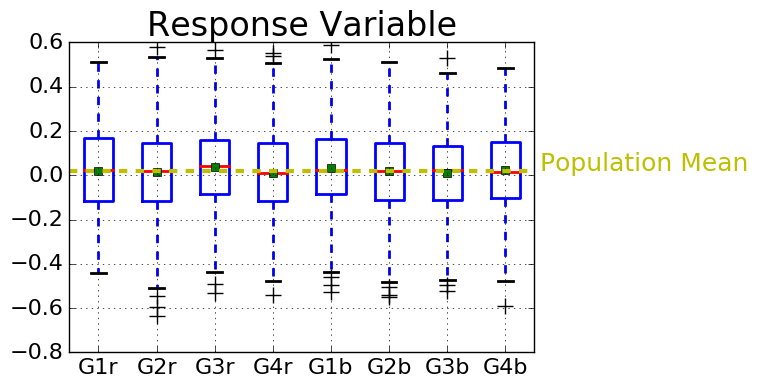

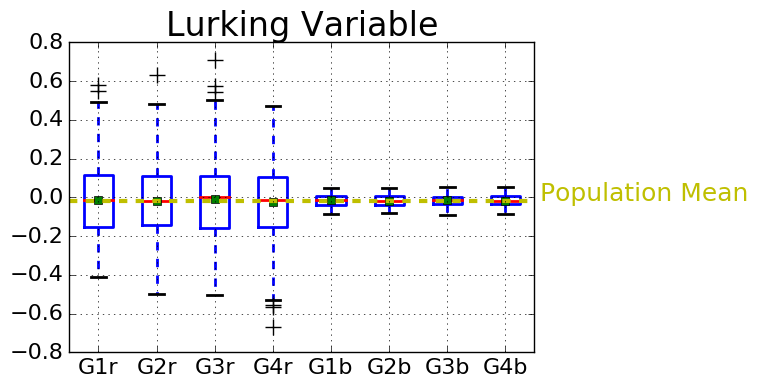

In [10]:
parts = experiment_response.boxplot(showmeans=True,figsize=gold,fontsize=16,return_type='dict')
fix_boxplot(parts)
yticks(fontsize=16)
title("Response Variable",fontsize=24)
plot([0.5,8.5],population.mean()['response']*np.ones(2),'y--',linewidth=3)
text(8.6,population.mean()['response'],"Population Mean",color='y',fontsize=18)

figure()
parts = experiment_lurking.boxplot(showmeans=True,figsize=gold,fontsize=16,return_type='dict')
fix_boxplot(parts)
yticks(fontsize=16)
title("Lurking Variable",fontsize=24)
plot([0.5,8.5],population.mean()['lurking']*np.ones(2),'y--',linewidth=3)
text(8.6,population.mean()['lurking'],"Population Mean",color='y',fontsize=18)

The results for the weaker correlation are similar to those with the strong correlation: the lurking variable is much more effectively controlled in the blocked grouping than the random. As the correlation is smaller, there is less improvement seen on the response variable distributions. That is what we would expect, with there being less and less of an effect as the correlation drops.

Which brings us to
### Part C

Same idea, this time with no correlation.

In [11]:
rho = 0.0
lurking = np.random.normal(loc=0.,scale=1.,size=80)
response = sqrt(1-rho**2)*np.random.normal(loc=0.,scale=1.,size=80)+rho*lurking

population = pd.DataFrame(np.array([lurking,response]).T,columns=['lurking','response'])
population.describe()

,lurking,response
count,80.000000,80.000000
mean,0.044389,-0.027017
std,0.985222,1.152158
min,-2.149850,-3.654611
25%,-0.714245,-0.579756
50%,0.034390,0.072666
75%,0.851300,0.621284
max,1.878055,2.782226


,lurking,response
lurking,1.000000,0.050285
response,0.050285,1.000000


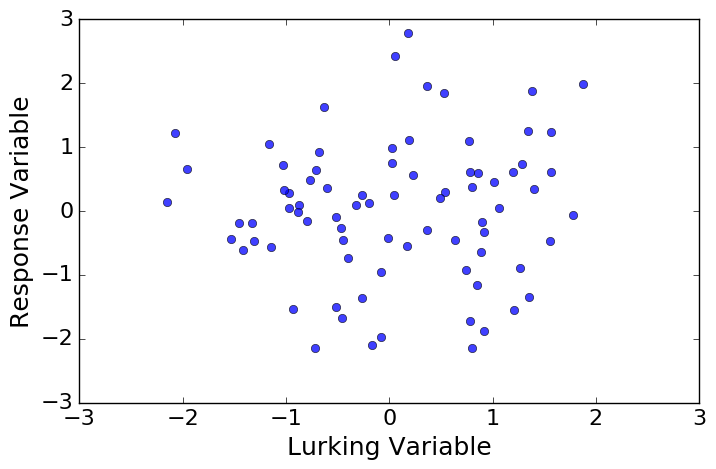

In [12]:
figure(figsize=gold)
plot(lurking,response,'o',alpha=0.75)
xlabel("Lurking Variable",fontsize=18)
ylabel("Response Variable",fontsize=18)
xticks(fontsize=16)
yticks(fontsize=16)
axis([-3,3,-3,3])
population.corr()

In [13]:
# Start with empty DataFrames
experiment_response = pd.DataFrame(columns=['G1r','G2r','G3r','G4r','G1b','G2b','G3b','G4b'])
experiment_lurking = pd.DataFrame(columns=['G1r','G2r','G3r','G4r','G1b','G2b','G3b','G4b'])

for i in tqdm(range(500)):
    
    # simple random assignment
    random_groups = np.array([1,2,3,4]).repeat(20)
    np.random.shuffle(random_groups)

    # blocked assignment
    ### By finding the index order for the lurking variable with argsort, we can unravel
    ### the shuffled assignment to get the original index assignments this way:
    order = lurking.argsort()
    block_groups = np.array([[1,2,3,4]]).repeat(20,axis=0)
    for block in block_groups:
        np.random.shuffle(block)
    block_groups = block_groups.flatten()[order.argsort()]

    # create a DataFrame that includes the group assignments
    groups = population.copy()
    groups['random'] = pd.Series(random_groups, index=groups.index)
    groups['blocked'] = pd.Series(block_groups, index=groups.index)
    
    # find the mean response variable for each group and add to the DataFrame
    new_data = {'G1r':groups.groupby(by='random')['response'].mean()[1],
                'G2r':groups.groupby(by='random')['response'].mean()[2],
                'G3r':groups.groupby(by='random')['response'].mean()[3],
                'G4r':groups.groupby(by='random')['response'].mean()[4],
                'G1b':groups.groupby(by='blocked')['response'].mean()[1],
                'G2b':groups.groupby(by='blocked')['response'].mean()[2],
                'G3b':groups.groupby(by='blocked')['response'].mean()[3],
                'G4b':groups.groupby(by='blocked')['response'].mean()[4]}
    experiment_response = experiment_response.append(new_data, ignore_index=True)
    
    # find the mean lurking variable for each group and add to the DataFrame
    new_data = {'G1r':groups.groupby(by='random')['lurking'].mean()[1],
                'G2r':groups.groupby(by='random')['lurking'].mean()[2],
                'G3r':groups.groupby(by='random')['lurking'].mean()[3],
                'G4r':groups.groupby(by='random')['lurking'].mean()[4],
                'G1b':groups.groupby(by='blocked')['lurking'].mean()[1],
                'G2b':groups.groupby(by='blocked')['lurking'].mean()[2],
                'G3b':groups.groupby(by='blocked')['lurking'].mean()[3],
                'G4b':groups.groupby(by='blocked')['lurking'].mean()[4]}
    experiment_lurking = experiment_lurking.append(new_data, ignore_index=True)

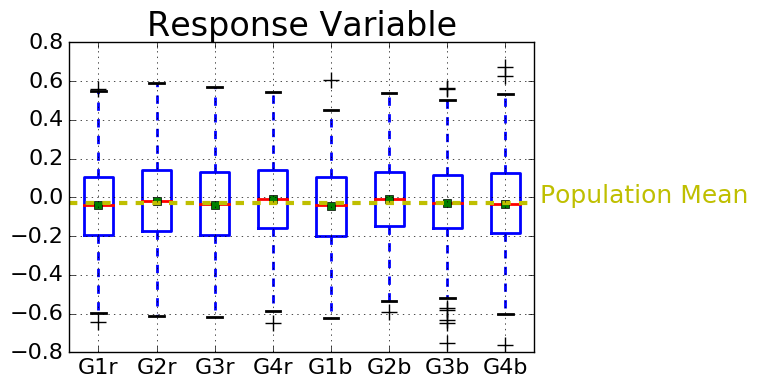

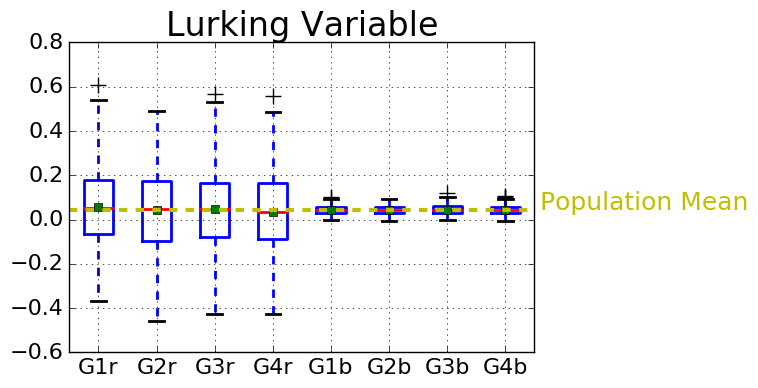

In [14]:
parts = experiment_response.boxplot(showmeans=True,figsize=gold,fontsize=16,return_type='dict')
fix_boxplot(parts)
yticks(fontsize=16)
title("Response Variable",fontsize=24)
plot([0.5,8.5],population.mean()['response']*np.ones(2),'y--',linewidth=3)
text(8.6,population.mean()['response'],"Population Mean",color='y',fontsize=18)

figure()
parts = experiment_lurking.boxplot(showmeans=True,figsize=gold,fontsize=16,return_type='dict')
fix_boxplot(parts)
yticks(fontsize=16)
title("Lurking Variable",fontsize=24)
plot([0.5,8.5],population.mean()['lurking']*np.ones(2),'y--',linewidth=3)
text(8.6,population.mean()['lurking'],"Population Mean",color='y',fontsize=18)

In this final trial, we see a large difference in controlling the lurking variable, but no meaningful difference in the resulting distributions of the response variable. We expect this, because blocking for a lurking variable will be no different then just a random grouping.

That said, it is important to note that the result cannot get worse by blocking for a lurking variable, so nothing is lost by making the attempt. Often, we don't know if a lurking variable would have an impact on our results, so it can be a good idea to block the groups anyway. That way, if there is a correlation, we can average its effect out; if there's not a correlation, then the only thing we lose is a little extra effort.